<a href="https://colab.research.google.com/github/AkshayViru/CorrMCNN/blob/main/Invictus_CorrMCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing all the necessary packages**

In [3]:
import torch
import pprint
import numpy as np
import torchvision
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchsummary import summary
from matplotlib.pyplot import figure
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ExponentialLR

In [2]:
batch_size=100
train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST(root='dataset/',train=True,transform=transforms.ToTensor(),download=True),batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST(root='dataset/',train=False,transform=transforms.ToTensor(),download=True),batch_size=batch_size)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Overview of the dataset



**************************** 9 images split into 2 halves ****************************


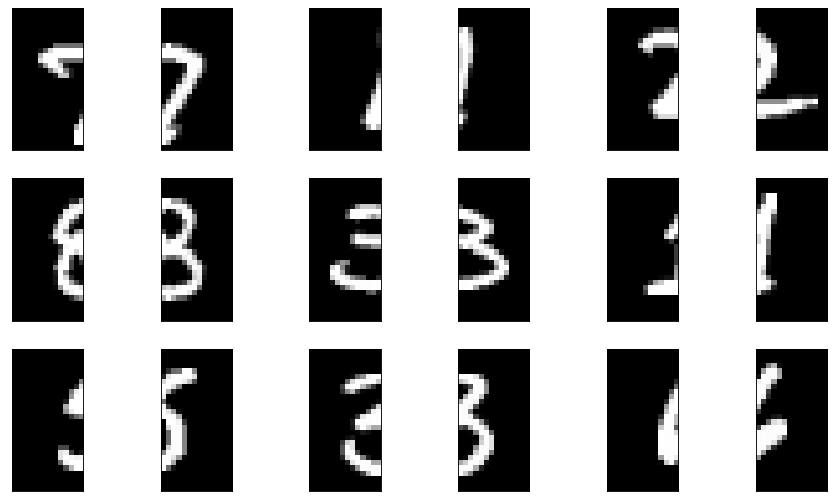

In [4]:
i = 1
j = 1
img_itr = 52

figure(figsize=(14, 8), dpi=80)

print('**************************** 9 images split into 2 halves ****************************')

for image_batch in train_loader:
    view1_batch = image_batch[0][img_itr:img_itr+9,0:1,0:28,0:14]
    view2_batch = image_batch[0][img_itr:img_itr+9,0:1,0:28,14:28]

    plt.subplot(3, 6, (6*(i-1))+j)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(view1_batch[0].reshape(28,14), cmap='gray', interpolation='none')

    plt.subplot(3, 6, (6*(i-1))+j+1)
    plt.imshow(view2_batch[0].reshape(28,14), cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
    j+=2
    if(j > 6):
      j = 1
      i += 1
    if(i == 4):
      break

plt.show()

In [5]:
def correlaton(x,y):
  vx = x - torch.mean(x)
  vy = y - torch.mean(y)
  cost = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2)))
  return cost

def plot_gp(x,y,str1,str2):
    plt.plot(x, y)
    plt.xlabel('Epochs')
    plt.ylabel(str1)
    plt.title(str2)
    plt.show()
      

# Model

In [ ]:
class MAE(nn.Module):
    def __init__(self):
        super(MAE,self).__init__()
        self.view1_convolution_L1=nn.Conv2d(1,200,3)
        self.view2_convolution_L1=nn.Conv2d(1,200,3)
        self.view1_pooling_L=nn.MaxPool2d(2)
        self.view2_pooling_L=nn.MaxPool2d(2)
        self.view1_batch_norm_L1=nn.BatchNorm2d(200)
        self.view2_batch_norm_L1=nn.BatchNorm2d(200)
        self.view1_dropout_L1=nn.Dropout(p=0.2)
        self.view2_dropout_L1=nn.Dropout(p=0.2)
        self.view1_convolution_L2=nn.Conv2d(200,100,3)
        self.view2_convolution_L2=nn.Conv2d(200,100,3)
        self.view1_batch_norm_L2=nn.BatchNorm2d(100)
        self.view2_batch_norm_L2=nn.BatchNorm2d(100)
        self.view1_dropout_L2=nn.Dropout(p=0.2)
        self.view2_dropout_L2=nn.Dropout(p=0.2)
        self.view1_hidden_layer_1=nn.Linear(1000,640)
        self.view2_hidden_layer_1=nn.Linear(1000,640)
        self.view1_hidden_layer_2=nn.Linear(640,320)
        self.view2_hidden_layer_2=nn.Linear(640,320)
        self.joint_common_rep=nn.Linear(320,100)
        self.view1_hidden_Layer_decoding=nn.Linear(100,294)
        self.view2_hidden_Layer_decoding=nn.Linear(100,294)
        self.view1_Upsampling=nn.Upsample(size=(26,12))
        self.view2_Upsampling=nn.Upsample(size=(26,12))
        self.view1_deconvolution=nn.ConvTranspose2d(3,1,3)
        self.view2_deconvolution=nn.ConvTranspose2d(3,1,3)


    def forward(self,inp_view1,inp_view2):
        view1={}
        view2={}
        view1["Layer"] = self.view1_convolution_L1(inp_view1)
        view2["Layer"] = self.view2_convolution_L1(inp_view2)
        view1["Layer"] = F.relu(view1["Layer"])
        view2["Layer"] = F.relu(view2["Layer"])
        view1["Layer"] = self.view1_pooling_L(view1["Layer"])
        view2["Layer"] = self.view2_pooling_L(view2["Layer"])
        view1["Layer"] = self.view1_batch_norm_L1(view1["Layer"])
        view2["Layer"] = self.view2_batch_norm_L1(view2["Layer"])
        view1["Layer"] = self.view1_dropout_L1(view1["Layer"])
        view2["Layer"] = self.view2_dropout_L1(view2["Layer"])
        view1["Layer"] = self.view1_convolution_L2(view1["Layer"])
        view2["Layer"] = self.view2_convolution_L2(view2["Layer"])
        view1["Layer"] = F.relu(view1["Layer"])
        view2["Layer"] = F.relu(view2["Layer"])
        view1["Layer"] = self.view1_pooling_L(view1["Layer"])
        view2["Layer"] = self.view2_pooling_L(view2["Layer"])
        view1["Layer"] = self.view1_batch_norm_L2(view1["Layer"])
        view2["Layer"] = self.view2_batch_norm_L2(view2["Layer"])
        view1["Layer"] = self.view1_dropout_L1(view1["Layer"])
        view2["Layer"] = self.view2_dropout_L1(view2["Layer"])
        view1["Layer"] = view1["Layer"].view(-1,1000)
        view2["Layer"] = view2["Layer"].view(-1,1000)
        view1["Hidden_Layer_1"] = self.view1_hidden_layer_1(view1["Layer"])
        view2["Hidden_Layer_1"] = self.view2_hidden_layer_1(view2["Layer"])
        view1["Hidden_Layer_1"] = F.relu(view1["Hidden_Layer_1"])
        view2["Hidden_Layer_1"] = F.relu(view2["Hidden_Layer_1"])
        view1["Hidden_Layer_2"] = self.view1_hidden_layer_2(view1["Hidden_Layer_1"])
        view2["Hidden_Layer_2"] = self.view2_hidden_layer_2(view2["Hidden_Layer_1"])
        view1["Hidden_Layer_2"] = F.relu(view1["Hidden_Layer_2"])
        view2["Hidden_Layer_2"] = F.relu(view2["Hidden_Layer_2"])
        joint_common_representation = view1["Hidden_Layer_2"] + view2["Hidden_Layer_2"]
        joint_common_representation = self.joint_common_rep(joint_common_representation)
        joint_common_representation = F.relu(joint_common_representation)
        view1["reconstructed"] = self.view1_hidden_Layer_decoding(joint_common_representation)
        view2["reconstructed"] = self.view2_hidden_Layer_decoding(joint_common_representation)
        view1["reconstructed"] = F.relu(view1["reconstructed"])
        view2["reconstructed"] = F.relu(view2["reconstructed"])
        view1["reconstructed"] = view1["reconstructed"].reshape(-1,3,14,7)
        view2["reconstructed"] = view2["reconstructed"].reshape(-1,3,14,7)
        view1["reconstructed"] = self.view1_Upsampling(view1["reconstructed"])
        view2["reconstructed"] = self.view2_Upsampling(view2["reconstructed"])
        view1["reconstructed"] = self.view1_deconvolution(view1["reconstructed"])
        view2["reconstructed"] = self.view2_deconvolution(view2["reconstructed"])
        return view1,view2,joint_common_representation

In [ ]:
def fit(model,train_loader,num_epoch,optimizer):
    ep=[]
    losses=[]
        
    for epoch in range(num_epoch):
        count=0
        print("epoch: ",epoch,end=" ")
        epoch_loss=0.0
        l1,l2,l3,l4,l5,l6,l7=0,0,0,0,0,0,0
        for image_batch in train_loader:
            self_reconstruction_loss={}
            cross_reconstruction_loss={}
            step_computation_loss={}
            view1_batch = image_batch[0][0:batch_size,0:1,0:28,0:14]
            init_view1 = torch.zeros(view1_batch.shape)
            view2_batch = image_batch[0][0:batch_size,0:1,0:28,14:28]
            init_view2 = torch.zeros(view2_batch.shape)
            view1_original,view2_original,joint_common_representation = model(view1_batch,view2_batch)
            self_reconstruction_loss["L1"]=F.mse_loss(view1_original["reconstructed"],view1_batch)
            self_reconstruction_loss["L1"]+=F.mse_loss(view2_original["reconstructed"],view2_batch)
            view1_left,view2_left,JCR_left = model(view1_batch,init_view2)
            view1_right,view2_right,JCR_right = model(init_view1,view2_batch)
            cross_reconstruction_loss["L2"]=F.mse_loss(view1_left["reconstructed"],view1_batch)
            cross_reconstruction_loss["L2"]+=F.mse_loss(view2_left["reconstructed"],view2_batch)
            cross_reconstruction_loss["L3"]=F.mse_loss(view1_right["reconstructed"],view1_batch)
            cross_reconstruction_loss["L3"]+=F.mse_loss(view2_right["reconstructed"],view2_batch)
            cross_reconstruction_loss["L5"]=F.mse_loss(view1_left["reconstructed"],view1_right["reconstructed"])
            cross_reconstruction_loss["L5"]+=F.mse_loss(view2_left["reconstructed"],view2_right["reconstructed"])
            step_computation_loss["L4"]=F.mse_loss(view1_original["Hidden_Layer_1"],view2_original["Hidden_Layer_1"])
            step_computation_loss["L4"]+=F.mse_loss(view1_original["Hidden_Layer_2"],view2_original["Hidden_Layer_2"])
            correlation_loss={}
            lambda_L6=-0.02
            lambda1_L7=-0.003
            lambda2_L7=-0.05
            correlation_loss["L6"]=lambda_L6*correlaton(JCR_left,JCR_right)
            correlation_loss["L7"]=lambda1_L7*correlaton(view1_original["Hidden_Layer_1"],view2_original["Hidden_Layer_1"]) 
            correlation_loss["L7"]+=lambda2_L7*correlaton(view1_original["Hidden_Layer_2"],view2_original["Hidden_Layer_2"])
            l1+=self_reconstruction_loss["L1"].item()
            l2+=cross_reconstruction_loss["L2"].item()
            l3+=cross_reconstruction_loss["L3"].item()
            l4+=step_computation_loss["L4"].item()
            l5+=cross_reconstruction_loss["L5"].item()
            l6+=correlation_loss["L6"].item()
            l7+=correlation_loss["L7"].item()
            batch_loss=self_reconstruction_loss["L1"]+cross_reconstruction_loss["L2"]+cross_reconstruction_loss["L3"]+step_computation_loss["L4"]+cross_reconstruction_loss["L5"]+correlation_loss["L6"]+correlation_loss["L7"]
            epoch_loss+=batch_loss.item()
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
        print("L1 loss:",l1,"L2 loss:",l2,"L3 loss:",l3,"L4 loss:",l4,"L5 loss:",l5,"L6 loss:",l6,"L7 loss:",l7)
        loss_epoch["L1"].append(l1)
        loss_epoch["L2"].append(l2)
        loss_epoch["L3"].append(l3)
        loss_epoch["L4"].append(l4)
        loss_epoch["L5"].append(l5)
        loss_epoch["L6"].append(l6)
        loss_epoch["L7"].append(l7)
        losses.append(epoch_loss)
        print("Loss",epoch_loss)
        torch.save(model.state_dict(), "model_"+str(epoch)+".pth")
        ep.append(epoch)
    return losses,model,ep
        

# Training

In [ ]:
loss_epoch={"L1":[],"L2":[],"L3":[],"L4":[],"L5":[],"L6":[],"L7":[]}
ep = [i for i in range(0,21)]

num_of_epochs=21

model = MAE()
optimizer = optim.Adam(model.parameters(),lr=0.001)
loss,model,ep=fit(model,train_loader,num_of_epochs,optimizer)

epoch:  0 L1 loss: 91.66947425156832 L2 loss: 92.43685837090015 L3 loss: 92.95785794407129 L4 loss: 2.5340027920901775 L5 loss: 0.9364670814320561 L6 loss: -11.802657188382 L7 loss: -30.689355457572674
Loss 238.0426478087902
epoch:  1 L1 loss: 54.98774892091751 L2 loss: 57.25545237213373 L3 loss: 57.84252808243036 L4 loss: 3.023673102259636 L5 loss: 3.6447012743446976 L6 loss: -11.603429576382041 L7 loss: -30.795212510973215
Loss 134.35546138882637
epoch:  2 L1 loss: 45.97940455377102 L2 loss: 48.580193392932415 L3 loss: 48.96583329886198 L4 loss: 2.896673657465726 L5 loss: 4.821461538784206 L6 loss: -11.587145203724504 L7 loss: -30.986665841192007
Loss 108.66975544393063
epoch:  3 L1 loss: 42.4029133208096 L2 loss: 45.1824923530221 L3 loss: 45.33924228698015 L4 loss: 2.5970817061606795 L5 loss: 5.21667426917702 L6 loss: -11.603582460433245 L7 loss: -31.09411682933569
Loss 98.04070501029491
epoch:  4 L1 loss: 40.490847524255514 L2 loss: 43.32989762350917 L3 loss: 43.49200006201863 L4 l

In [ ]:
torch.save(model.state_dict(), "model_final.pth")

# Graphs

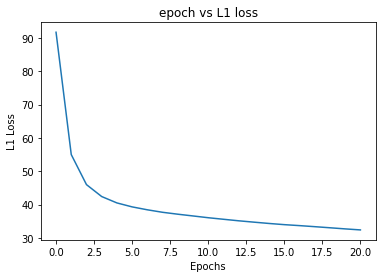

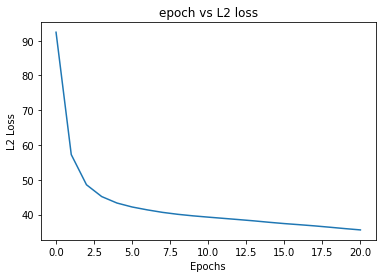

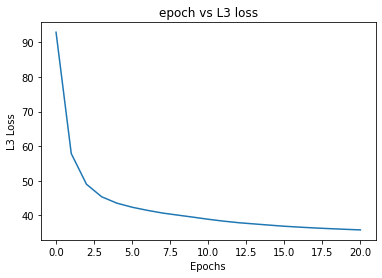

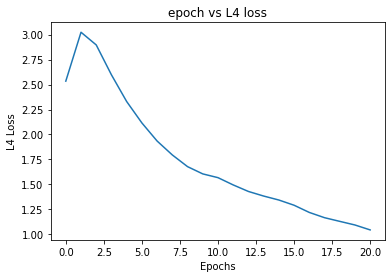

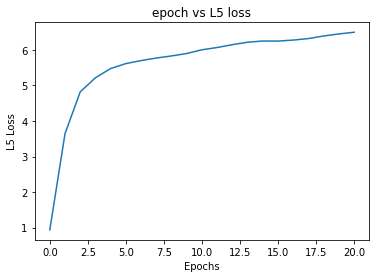

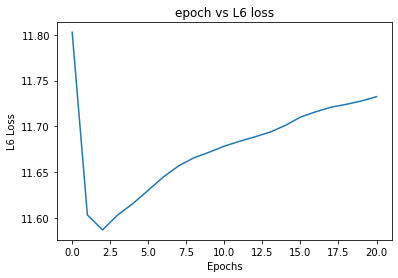

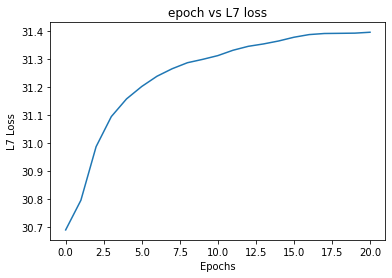

In [ ]:
plot_gp(ep,loss_epoch["L1"],"L1 Loss","epoch vs L1 loss")
plot_gp(ep,loss_epoch["L2"],"L2 Loss","epoch vs L2 loss")
plot_gp(ep,loss_epoch["L3"],"L3 Loss","epoch vs L3 loss")
plot_gp(ep,loss_epoch["L4"],"L4 Loss","epoch vs L4 loss")
plot_gp(ep,loss_epoch["L5"],"L5 Loss","epoch vs L5 loss")
l6_pos=np.array(loss_epoch["L6"])*-1
l6_pos=list(l6_pos)
plot_gp(ep,l6_pos,"L6 Loss","epoch vs L6 loss")
l7_pos=np.array(loss_epoch["L7"])*-1
l7_pos=list(l7_pos)
plot_gp(ep,l7_pos,"L7 Loss","epoch vs L7 loss")

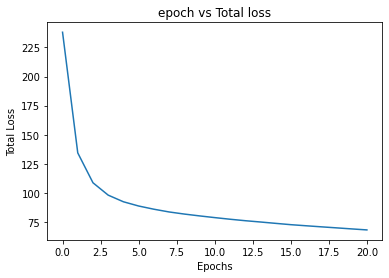

In [ ]:
plot_gp(ep,loss,"Total Loss","epoch vs Total loss")

# Reconstructions

In [ ]:
batch = next(iter(test_loader))
images = batch[0]
view1 = images[0:batch_size,0:1,0:28,0:14]
init_view1 = torch.zeros(view1.shape)
view2 = images[0:batch_size,0:1,0:28,14:28]
init_view2 = torch.zeros(view2.shape)
view1_original,view2_original,joint_common_representation = model(view1,view2)
view1_left,view2_left,JCR_left = model(view1,init_view2)
view1_right,view2_right,JCR_right = model(init_view1,view2)

In [ ]:
def plot_result(view1,view2,view2_original,view1_original,id):
    fig, axs = plt.subplots(1, 4,figsize=(70,70))
    axs[0].tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
    axs[0].imshow(view1[id].detach().reshape(28,14))
    axs[1].tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
    axs[1].imshow(view2_original[id].detach().reshape(28,14))
    axs[2].tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
    axs[2].imshow(view1_original[id].detach().reshape(28,14))
    axs[3].tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
    axs[3].imshow(view2[id].detach().reshape(28,14))
    plt.subplots_adjust(left=0.65,bottom=0.1,right=0.7,top=0.2,wspace=0.1,hspace=0.1)
    plt.show()

Self - reconstruction


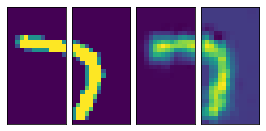

Cross - reconstruction


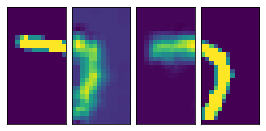




Self - reconstruction


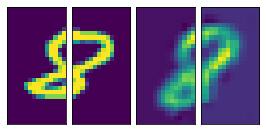

Cross - reconstruction


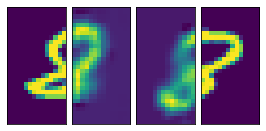




Self - reconstruction


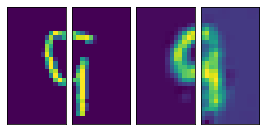

Cross - reconstruction


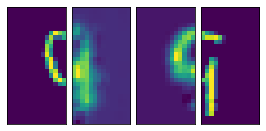




Self - reconstruction


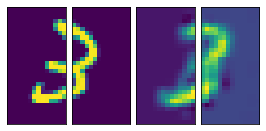

Cross - reconstruction


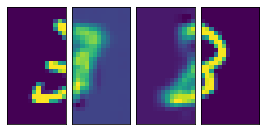




Self - reconstruction


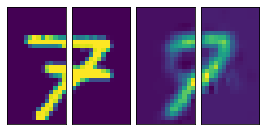

Cross - reconstruction


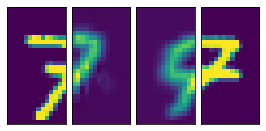




Self - reconstruction


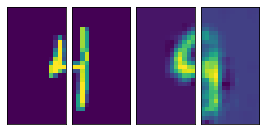

Cross - reconstruction


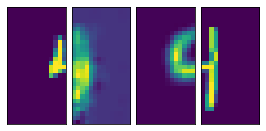




Self - reconstruction


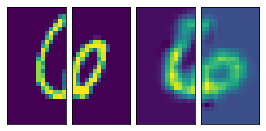

Cross - reconstruction


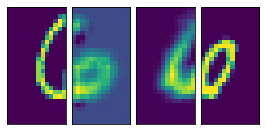




Self - reconstruction


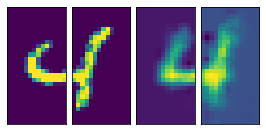

Cross - reconstruction


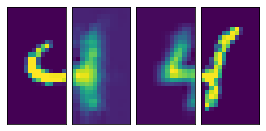




Self - reconstruction


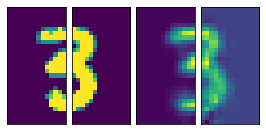

Cross - reconstruction


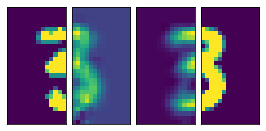




Self - reconstruction


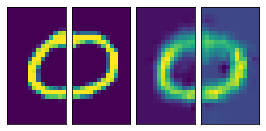

Cross - reconstruction


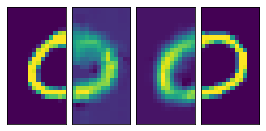




Self - reconstruction


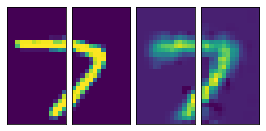

Cross - reconstruction


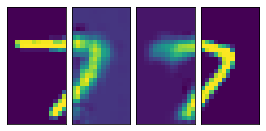




Self - reconstruction


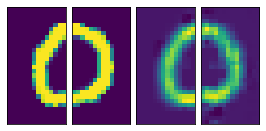

Cross - reconstruction


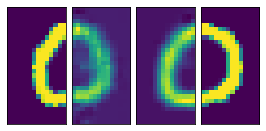




Self - reconstruction


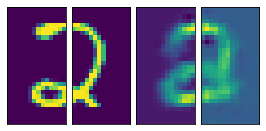

Cross - reconstruction


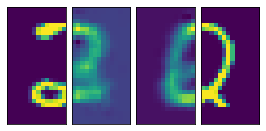




Self - reconstruction


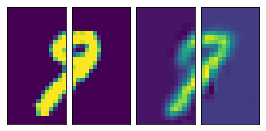

Cross - reconstruction


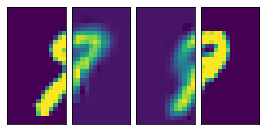




Self - reconstruction


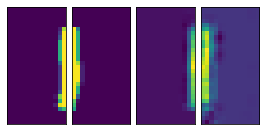

Cross - reconstruction


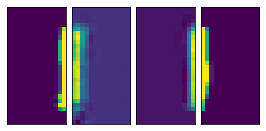




Self - reconstruction


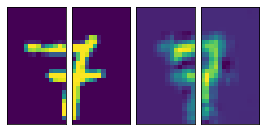

Cross - reconstruction


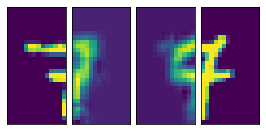




Self - reconstruction


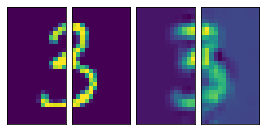

Cross - reconstruction


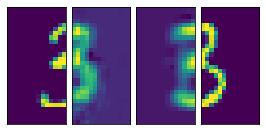




Self - reconstruction


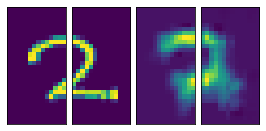

Cross - reconstruction


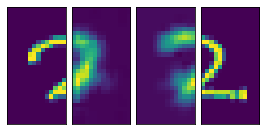




Self - reconstruction


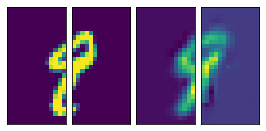

Cross - reconstruction


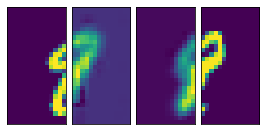




Self - reconstruction


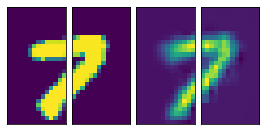

Cross - reconstruction


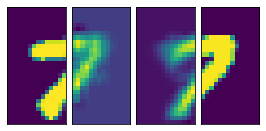




Self - reconstruction


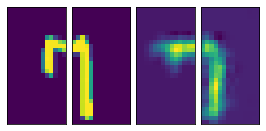

Cross - reconstruction


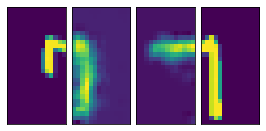




Self - reconstruction


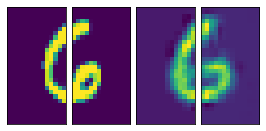

Cross - reconstruction


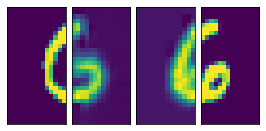




Self - reconstruction


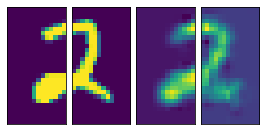

Cross - reconstruction


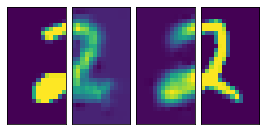




Self - reconstruction


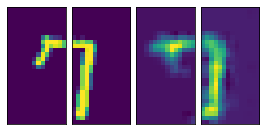

Cross - reconstruction


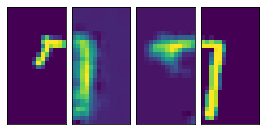




Self - reconstruction


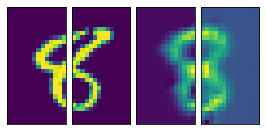

Cross - reconstruction


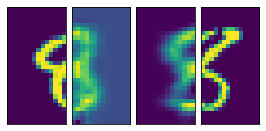




Self - reconstruction


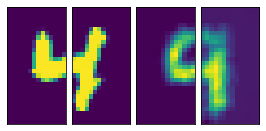

Cross - reconstruction


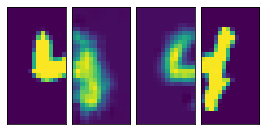




Self - reconstruction


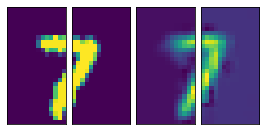

Cross - reconstruction


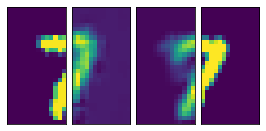




Self - reconstruction


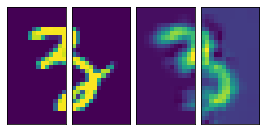

Cross - reconstruction


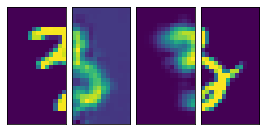




Self - reconstruction


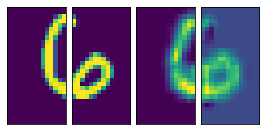

Cross - reconstruction


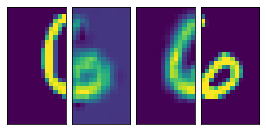




Self - reconstruction


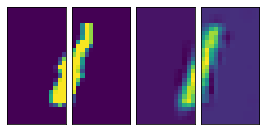

Cross - reconstruction


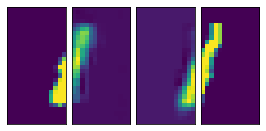




Self - reconstruction


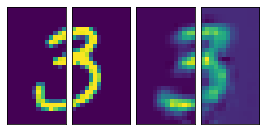

Cross - reconstruction


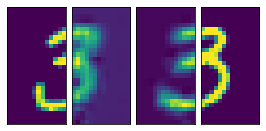




Self - reconstruction


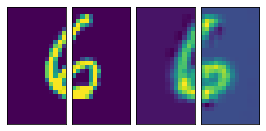

Cross - reconstruction


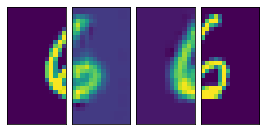




Self - reconstruction


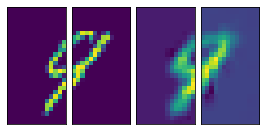

Cross - reconstruction


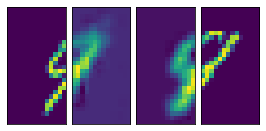




Self - reconstruction


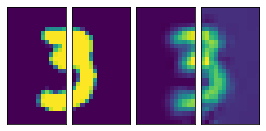

Cross - reconstruction


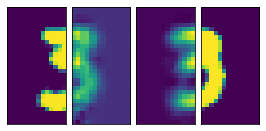




Self - reconstruction


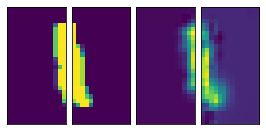

Cross - reconstruction


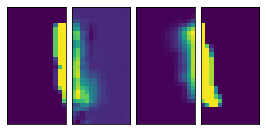




Self - reconstruction


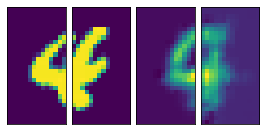

Cross - reconstruction


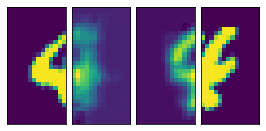




Self - reconstruction


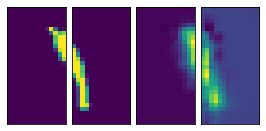

Cross - reconstruction


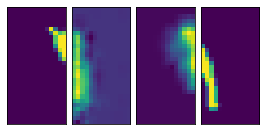




Self - reconstruction


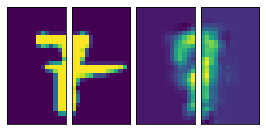

Cross - reconstruction


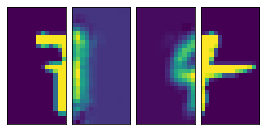




Self - reconstruction


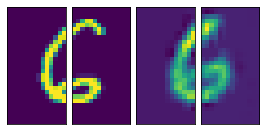

Cross - reconstruction


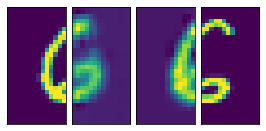




Self - reconstruction


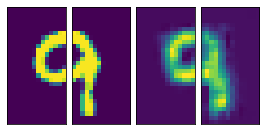

Cross - reconstruction


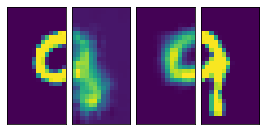

In [ ]:
for id in range(0,40):
  print('Self - reconstruction')
  plot_result(view1,view2_original["reconstructed"],view2,view1_original["reconstructed"],id)
  print('Cross - reconstruction')
  plot_result(view1,view2,view2_left["reconstructed"],view1_right["reconstructed"],id)
  print("\n"*2)